# Twitter Sentiment Analysis

In [418]:
import tweepy
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Define global font for EDA
font = {'family' : 'calibri',
        'weight' : 'normal',
        'size'   : 18}

## Data Collection (No need to re-run as data was saved to json)

In [70]:
API_KEY = 'VtLt0PooFdfryVk8ZBnzI2hJq'
API_SECRET = 'to5r9XTKt1s8YsNq2xAzKqImOO7QVnXhkJRGCaNf0ZFlPzrFW2'
TOKEN_KEY = '3344822685-x6uOBwsnJA2aJJMoyw20h62D8NwDcU2YE5ttVb0'
TOKEN_SECRET = 'CDsPJ9EZBxIH2APs4gZIuLxmwpANAJPTkK1CFFG8kTEqk'

auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(TOKEN_KEY, TOKEN_SECRET)
api = tweepy.API(auth)

In [88]:
query = '#airbnb'
cursor = tweepy.Cursor(api.search, q=query, lang="en",wait_on_rate_limit=True).items(5000)

In [89]:
tweets = [] # empty list to store tweets
for item in cursor:
    tweets.append(item._json) # extracts tweet data and saves it to tweets list

with open('Airbnb_tweets.json', 'w') as outfile: # opens file called hashchildlabor and saves tweets
    json.dump(tweets, outfile)

## Pre-process Tweets

In [394]:
df = pd.read_json ('Airbnb_tweets.json')
df.shape

(2499, 30)

In [395]:
df.head()

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2020-08-13 10:45:23+00:00,1293861198639902720,1293861198639902720,Pre lockdown writing session\n\n#airbnb \n#ind...,False,"{'hashtags': [{'text': 'airbnb', 'indices': [3...","{'media': [{'id': 1293861195162804225, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,0.0,en,NaN,NaN,NaN,NaN
1,2020-08-13 10:42:32+00:00,1293860483435499521,1293860483435499520,Airbnb has purchased the last Blockbuster. Why...,False,"{'hashtags': [{'text': 'Airbnb', 'indices': [8...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,0.0,en,NaN,NaN,NaN,NaN
2,2020-08-13 10:40:58+00:00,1293860087300317184,1293860087300317184,RT @narek_gevorgyan: #Twitter made anyone a Re...,False,"{'hashtags': [{'text': 'Twitter', 'indices': [...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,3,0,False,False,NaN,en,{'created_at': 'Wed Aug 12 16:58:00 +0000 2020...,NaN,NaN,NaN
3,2020-08-13 10:40:52+00:00,1293860064172933120,1293860064172933120,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,3,0,False,False,NaN,en,{'created_at': 'Thu Aug 13 10:26:22 +0000 2020...,NaN,NaN,NaN
4,2020-08-13 10:39:19+00:00,1293859674048036864,1293859674048036864,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,3,0,False,False,NaN,en,{'created_at': 'Thu Aug 13 10:26:22 +0000 2020...,NaN,NaN,NaN


In [92]:
df.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'retweeted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status'],
      dtype='object')

In [396]:
# Remove redundant features
columns_to_keep = ['created_at','text','entities','retweet_count']
df_columns_keep = df[columns_to_keep]
df_columns_keep

,created_at,text,entities,retweet_count
0,2020-08-13 10:45:23+00:00,Pre lockdown writing session\n\n#airbnb \n#ind...,"{'hashtags': [{'text': 'airbnb', 'indices': [3...",0
1,2020-08-13 10:42:32+00:00,Airbnb has purchased the last Blockbuster. Why...,"{'hashtags': [{'text': 'Airbnb', 'indices': [8...",0
2,2020-08-13 10:40:58+00:00,RT @narek_gevorgyan: #Twitter made anyone a Re...,"{'hashtags': [{'text': 'Twitter', 'indices': [...",3
3,2020-08-13 10:40:52+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3
4,2020-08-13 10:39:19+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3
...,...,...,...,...
2494,2020-08-04 17:58:16+00:00,#moustachehouserome #roma #rome #airbnb #tripa...,"{'hashtags': [{'text': 'moustachehouserome', '...",0
2495,2020-08-04 17:54:15+00:00,Penthouse sea view 144 m2 two bedshttps://www....,"{'hashtags': [{'text': 'airbnb', 'indices': [1...",0
2496,2020-08-04 17:53:34+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3
2497,2020-08-04 17:53:21+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3


In [397]:
# split date and time
df_columns_keep['Date'] = df_columns_keep['created_at'].dt.strftime('%d/%m')
df_columns_keep['Time'] = df_columns_keep['created_at'].dt.strftime('%H:%M')
#df_columns_keep = df_columns_keep.drop(columns='created_at')
df_columns_keep

<ipython-input-397-84b8b308c0fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_keep['Date'] = df_columns_keep['created_at'].dt.strftime('%d/%m')
<ipython-input-397-84b8b308c0fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_keep['Time'] = df_columns_keep['created_at'].dt.strftime('%H:%M')


,created_at,text,entities,retweet_count,Date,Time
0,2020-08-13 10:45:23+00:00,Pre lockdown writing session\n\n#airbnb \n#ind...,"{'hashtags': [{'text': 'airbnb', 'indices': [3...",0,13/08,10:45
1,2020-08-13 10:42:32+00:00,Airbnb has purchased the last Blockbuster. Why...,"{'hashtags': [{'text': 'Airbnb', 'indices': [8...",0,13/08,10:42
2,2020-08-13 10:40:58+00:00,RT @narek_gevorgyan: #Twitter made anyone a Re...,"{'hashtags': [{'text': 'Twitter', 'indices': [...",3,13/08,10:40
3,2020-08-13 10:40:52+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:40
4,2020-08-13 10:39:19+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:39
...,...,...,...,...,...,...
2494,2020-08-04 17:58:16+00:00,#moustachehouserome #roma #rome #airbnb #tripa...,"{'hashtags': [{'text': 'moustachehouserome', '...",0,04/08,17:58
2495,2020-08-04 17:54:15+00:00,Penthouse sea view 144 m2 two bedshttps://www....,"{'hashtags': [{'text': 'airbnb', 'indices': [1...",0,04/08,17:54
2496,2020-08-04 17:53:34+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53
2497,2020-08-04 17:53:21+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53


## Exploratory Data Analysis

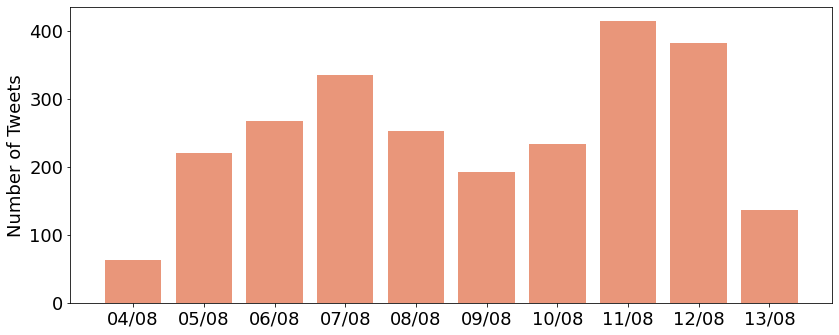

In [233]:
count = df_columns_keep.groupby(['Date']).count()
count = count.iloc[:,3]
date = df_columns_keep.Date.unique()
date = np.flip(date)

plt.figure(figsize=(12,5))
plt.bar(date, count, color = 'darksalmon')
plt.ylabel('Number of Tweets')
mpl.rc('font', **font)
plt.tight_layout()
plt.savefig('01_EDA_Num_Tweets_date.png')
plt.show()

It is evident that the tweets from August 4 are fewer because of the amount of data collected. In general, there is no clear pattern on the number of tweets per day however, 11 and 12 August did cause a spike. Could this be because of reports about Airbnb's IPO?

In [398]:
# Split time to morning, afternoon, evening and night

df_columns_keep =df_columns_keep.assign(session=pd.cut(df_columns_keep.created_at.dt.hour,
                            [0,6,12,18,23],
                            labels=['Night','Morning','Afternoon','Evening'],
                            include_lowest=True))
df_columns_keep

,created_at,text,entities,retweet_count,Date,Time,session
0,2020-08-13 10:45:23+00:00,Pre lockdown writing session\n\n#airbnb \n#ind...,"{'hashtags': [{'text': 'airbnb', 'indices': [3...",0,13/08,10:45,Morning
1,2020-08-13 10:42:32+00:00,Airbnb has purchased the last Blockbuster. Why...,"{'hashtags': [{'text': 'Airbnb', 'indices': [8...",0,13/08,10:42,Morning
2,2020-08-13 10:40:58+00:00,RT @narek_gevorgyan: #Twitter made anyone a Re...,"{'hashtags': [{'text': 'Twitter', 'indices': [...",3,13/08,10:40,Morning
3,2020-08-13 10:40:52+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:40,Morning
4,2020-08-13 10:39:19+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:39,Morning
...,...,...,...,...,...,...,...
2494,2020-08-04 17:58:16+00:00,#moustachehouserome #roma #rome #airbnb #tripa...,"{'hashtags': [{'text': 'moustachehouserome', '...",0,04/08,17:58,Afternoon
2495,2020-08-04 17:54:15+00:00,Penthouse sea view 144 m2 two bedshttps://www....,"{'hashtags': [{'text': 'airbnb', 'indices': [1...",0,04/08,17:54,Afternoon
2496,2020-08-04 17:53:34+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53,Afternoon
2497,2020-08-04 17:53:21+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53,Afternoon


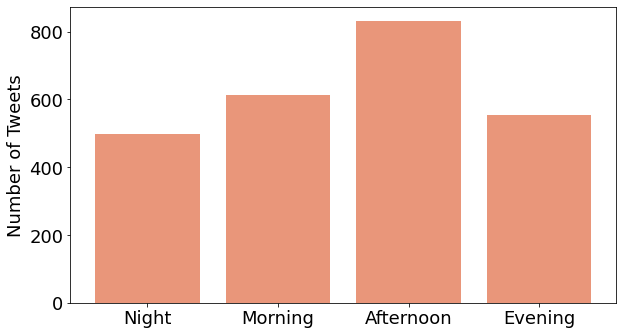

In [232]:
count = df_columns_keep.groupby(['session']).count()
count = count.iloc[:,3]
time_of_day = ['Night','Morning','Afternoon','Evening']

plt.figure(figsize=(9,5))
plt.bar(time_of_day, count, color = 'darksalmon')
plt.ylabel('Number of Tweets')
mpl.rc('font', **font)
plt.tight_layout()
plt.savefig('02_EDA_Num_Tweets_time_of_day.png')
plt.show()


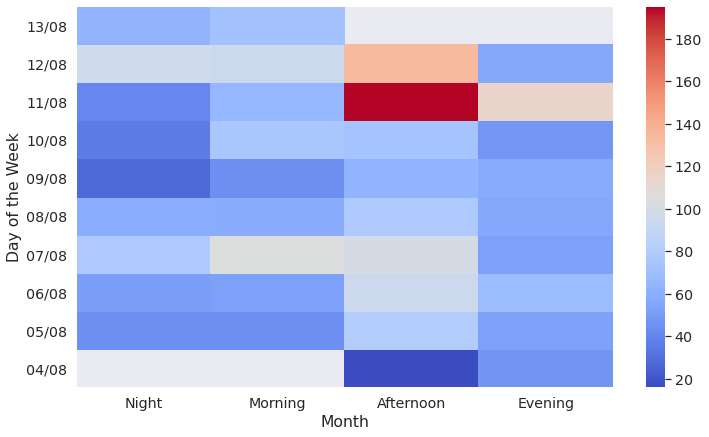

In [250]:
count = df_columns_keep.groupby(['Date','session']).count()
count = pd.DataFrame(count.iloc[:,3])

pivot = pd.pivot_table(data=count,
                    index='Date',
                    values='retweet_count',
                    columns='session')

sns.set(rc={'figure.figsize':(12,7)})
sns.set(font_scale=1.3)
plt = sns.heatmap(pivot, cmap='coolwarm')
plt.set(xlabel='Month', ylabel='Day of the Week')
plt.invert_yaxis()
plt.figure.savefig('03_Date_Time_Heatmap.png')

## Data Preparation for Modelling

In [399]:
## Add tweet labels (positive, neutral or negative)
data_polarity = []
for tweet in df_columns_keep.text:
    polarity = TextBlob(tweet)
    if polarity.sentiment.polarity > 0:
        data_polarity.append('positive')
    elif polarity.sentiment.polarity == 0:
        data_polarity.append('neutral')
    else:
        data_polarity.append('negative')
    
data_polarity = pd.DataFrame(data_polarity, columns = {'Polarity'})

df_columns_keep['Polarity_of_tweet'] = data_polarity
df_columns_keep

,created_at,text,entities,retweet_count,Date,Time,session,Polarity_of_tweet
0,2020-08-13 10:45:23+00:00,Pre lockdown writing session\n\n#airbnb \n#ind...,"{'hashtags': [{'text': 'airbnb', 'indices': [3...",0,13/08,10:45,Morning,neutral
1,2020-08-13 10:42:32+00:00,Airbnb has purchased the last Blockbuster. Why...,"{'hashtags': [{'text': 'Airbnb', 'indices': [8...",0,13/08,10:42,Morning,neutral
2,2020-08-13 10:40:58+00:00,RT @narek_gevorgyan: #Twitter made anyone a Re...,"{'hashtags': [{'text': 'Twitter', 'indices': [...",3,13/08,10:40,Morning,neutral
3,2020-08-13 10:40:52+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:40,Morning,neutral
4,2020-08-13 10:39:19+00:00,RT @Rahul_2503: @BluzelleHQ AirBNB of Database...,"{'hashtags': [], 'symbols': [], 'user_mentions...",3,13/08,10:39,Morning,neutral
...,...,...,...,...,...,...,...,...
2494,2020-08-04 17:58:16+00:00,#moustachehouserome #roma #rome #airbnb #tripa...,"{'hashtags': [{'text': 'moustachehouserome', '...",0,04/08,17:58,Afternoon,neutral
2495,2020-08-04 17:54:15+00:00,Penthouse sea view 144 m2 two bedshttps://www....,"{'hashtags': [{'text': 'airbnb', 'indices': [1...",0,04/08,17:54,Afternoon,neutral
2496,2020-08-04 17:53:34+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53,Afternoon,negative
2497,2020-08-04 17:53:21+00:00,RT @derivedfromdata: #Expedia June bookings fe...,"{'hashtags': [{'text': 'Expedia', 'indices': [...",3,04/08,17:53,Afternoon,negative


In [404]:
# Separate tweet and label
X = df_columns_keep['text']
y = df_columns_keep['Polarity_of_tweet']

In [405]:
vectorizer = CountVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(X)
X_vec.todense() # convert sparse matrix into dense matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [406]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)
X_tfidf = X_tfidf.todense()
X_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [411]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.30, random_state = 0)

## Modelling

In [413]:
LR_model = LogisticRegression(random_state=0, multi_class = 'multinomial',
                          max_iter = 1000, class_weight = 'balanced').fit(X_train, y_train)

In [421]:
SVM_model = LinearSVC().fit(X_train, y_train)

In [425]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

In [424]:
NB = MultinomialNB().fit(X_train, y_train)

/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Logistic Reg (baseline): 0.803346 (0.037546)


/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


SVM: 0.830220 (0.031396)


/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Random Forest: 0.792483 (0.024057)


/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Naive Bayes: 0.755307 (0.031046)


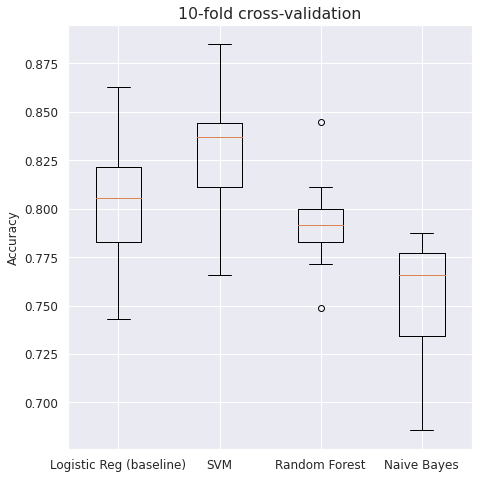

In [426]:
# List models to run CV
models = []
models.append(('Logistic Reg (baseline)', LR_model ))
models.append(('SVM', SVM_model ))
models.append(('Random Forest', RF_model ))
models.append(('Naive Bayes', NB ))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.figure(figsize=(7,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.boxplot(results, labels=names)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('10-fold cross-validation')
plt.tight_layout()
mpl.rc('font', **font)
plt.savefig('04_CV_Models.png')
plt.show()

## Evaluation 

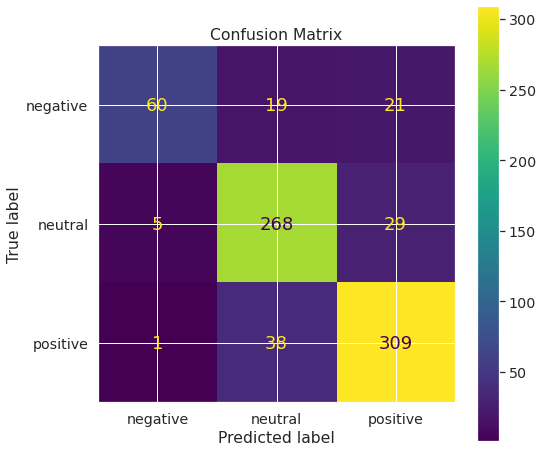

<Figure size 1440x1440 with 0 Axes>

In [427]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,8))
disp = plot_confusion_matrix(SVM_model, X_test, y_test, ax=ax)
plt.figure(figsize=(20,20))
disp.ax_.set_title('Confusion Matrix')
#fig.savefig('05_Confusion_Matrix.png')
plt.show()

In [423]:
y_pred = LR_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.64      0.74       100
     neutral       0.75      0.93      0.83       302
    positive       0.92      0.80      0.86       348

    accuracy                           0.83       750
   macro avg       0.85      0.79      0.81       750
weighted avg       0.85      0.83      0.83       750



## WordCloud

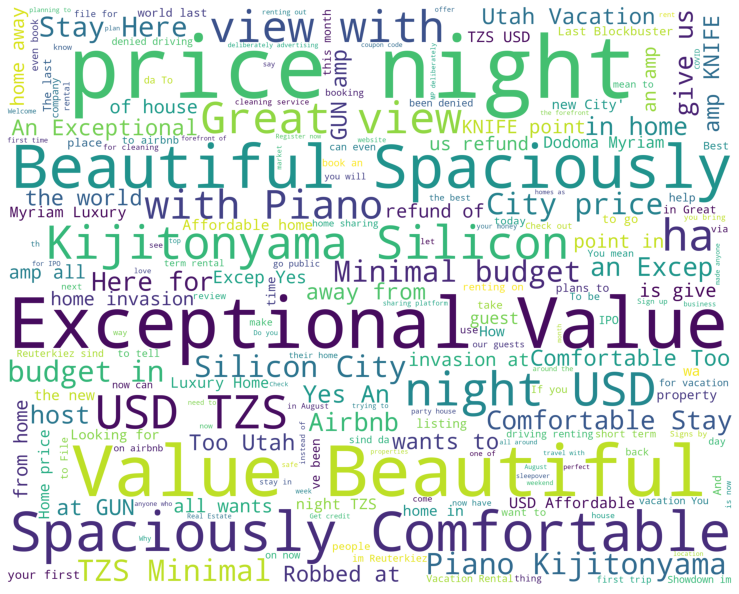

In [447]:
wordcloud_data = df_columns_keep['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                                and word != 'and'
                                and word != 'Avg'
                                and word != 'https'
                                and word != 'Airbnb'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.savefig('05_Wordcloud_.png')
    plt.axis('off')
    plt.show()

wordcloud_draw(wordcloud_data,'white')